# Spotify podcast dataset: inspection and cleaning
Aditya Chander

2022-10-21
_________
Components of this notebook:
* Inspecting structure of the .json transcript files
* Extracting the genres from the RSS feed files (.xml)
* Cleaning transcripts and storing them in an appropriate data structure

## Folder structure (from the README file provided by Spotify)

The data set is organized into subdirectories under the transcripts and audio directories by the first two characters of the show-id to avoid overwhelming filesystem operations. The show-ids and the episode-ids are alphanumeric character sequences of length 22. Since some operating systems do not distinguish between upper and lower case, the subdirectory paths are all in upper case and include both upper 
and lower case show-ids in the same subdirectory.

For English, the folder structure is:

* spotify-podcasts-2020/podcasts-transcripts/0/A/show_*/*.json
* spotify-podcasts-2020/podcasts-audio/0/A/show_*/*.ogg
* spotify-podcasts-2020/show-rss/0/A/show_*.xml
* spotify-podcasts-2020/metadata.tsv
* spotify-podcasts-2020/scripts/compliance.py
* spotify-podcasts-2020/scripts/delete_file.txt

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import string
from bs4 import BeautifulSoup

In [6]:
# folders for the subdirectories
# note that there are eight tranches, numbered 0 to 7. However, we'll just look at the first three as otherwise we'll end up with a huge number of podcasts.
TRANCHES = [str(i) for i in range(3)]
SUBTRANCHES = [str(i) for i in range(10)] + list(string.ascii_uppercase)

## Inspection

### The JSON transcript files
Once you're in a subtranche, you have folders corresponding to each show, then possibly several episodes per show (in .json format). Let's see what one of these files looks like.

In [18]:
tranche_idx = 0
subtranche_idx = 0
folder_idx = 0
file_idx = 0
test_directory = f'podcasts-no-audio-13GB/spotify-podcasts-2020/podcasts-transcripts/{TRANCHES[tranche_idx]}/{SUBTRANCHES[subtranche_idx]}'

subtranche_folders = os.listdir(test_directory)
show_folder = subtranche_folders[0]
show_files = os.listdir(f'{test_directory}/{show_folder}')

In [32]:
test_file = f'{test_directory}/{show_folder}/{show_files[file_idx]}'
with open(test_file) as f:
    test_json = json.load(f)
test_json

{'results': [{'alternatives': [{'transcript': 'Welcome back to GRE vocab.',
     'confidence': 0.8171201944351196,
     'words': [{'startTime': '0.900s', 'endTime': '1.200s', 'word': 'Welcome'},
      {'startTime': '1.200s', 'endTime': '1.500s', 'word': 'back'},
      {'startTime': '1.500s', 'endTime': '1.800s', 'word': 'to'},
      {'startTime': '1.800s', 'endTime': '2.300s', 'word': 'GRE'},
      {'startTime': '2.300s', 'endTime': '3.300s', 'word': 'vocab.'}]}]},
  {'alternatives': [{}]},
  {'alternatives': [{}]},
  {'alternatives': [{'transcript': " Before we continue. We just want to give a quick shout out to the people who make this podcast possible. Anchor anchor is everything you need to make a podcast in one place. They distribute your podcast for you. They have tools that allow you to record and edit everything right from your phone or computer. It's free the even allow you to put ads in your your podcast. It's pretty awesome. Go check it out download the free anchor app or go

This .json file has several components. The list of transcript components is under a nested key structure: 

* results
    * alternatives <-- many possible results for what the transcript is, but we'll always pick the first one.
        * transcript (either in paragraphs or word by word)
        
There are some blank dicts too.

Let's extract the transcripts by writing a function that extracts and concatenates the sentences together; then let's use it to process a whole folder of transcripts.

In [41]:
def get_transcript(json_dict):
    transcript = ''
    segments = json_dict['results']
    for segment in segments:
        transcript_dict = segment['alternatives'][0]
        if 'transcript' not in transcript_dict: 
            continue
        transcript += transcript_dict['transcript']
    return transcript

get_transcript(test_json)

"Welcome back to GRE vocab. Before we continue. We just want to give a quick shout out to the people who make this podcast possible. Anchor anchor is everything you need to make a podcast in one place. They distribute your podcast for you. They have tools that allow you to record and edit everything right from your phone or computer. It's free the even allow you to put ads in your your podcast. It's pretty awesome. Go check it out download the free anchor app or go to Anchored off dot f m-- to get started. Okay, let's get back to the show. Today's words are fatuous, silly and pointless apocryphal. Of doubtful authenticity, although widely circulated as being true usually in regards to a story or statement a credit e having an acrid smell accurate is having an irritant Lee Strong and unpleasant taste or smell angry bitter. Trench in see in size of - keenness and forcefulness of thought or expression or intellect euphony the quality of being pleasing to the ear, especially through a harm

In [65]:
for file in show_files:
    full_file = f'{test_directory}/{show_folder}/{file}'
    # print(full_file)
    with open(full_file) as f:
        tmp_json = json.load(f)
    print(get_transcript(tmp_json))
    print()

Welcome back to GRE vocab. Before we continue. We just want to give a quick shout out to the people who make this podcast possible. Anchor anchor is everything you need to make a podcast in one place. They distribute your podcast for you. They have tools that allow you to record and edit everything right from your phone or computer. It's free the even allow you to put ads in your your podcast. It's pretty awesome. Go check it out download the free anchor app or go to Anchored off dot f m-- to get started. Okay, let's get back to the show. Today's words are fatuous, silly and pointless apocryphal. Of doubtful authenticity, although widely circulated as being true usually in regards to a story or statement a credit e having an acrid smell accurate is having an irritant Lee Strong and unpleasant taste or smell angry bitter. Trench in see in size of - keenness and forcefulness of thought or expression or intellect euphony the quality of being pleasing to the ear, especially through a harmo

The above function works well! I assume for now that it'll work on the whole dataset (at least based on [this code](https://github.com/potsawee/podcast_trec2020/blob/main/data/processor.py) it ought to).

### Metadata

The metadata contains a bunch of information about each episode, which will become helpful when building podcast selection menus for the recommender engine.

Note that this contains all 105k podcasts; we're only looking at a subset of 38k from tranches 0 to 2.

In [52]:
metadata_df = pd.read_csv('podcasts-no-audio-13GB/metadata.tsv', sep='\t')
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105360 entries, 0 to 105359
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   show_uri                 105360 non-null  object 
 1   show_name                105360 non-null  object 
 2   show_description         105358 non-null  object 
 3   publisher                105360 non-null  object 
 4   language                 105360 non-null  object 
 5   rss_link                 105360 non-null  object 
 6   episode_uri              105360 non-null  object 
 7   episode_name             105360 non-null  object 
 8   episode_description      105155 non-null  object 
 9   duration                 105360 non-null  float64
 10  show_filename_prefix     105360 non-null  object 
 11  episode_filename_prefix  105360 non-null  object 
dtypes: float64(1), object(11)
memory usage: 9.6+ MB


Let's take a look at one row of the table.

In [56]:
metadata_df[metadata_df.episode_filename_prefix=='2FC8NWOUxmxflPBVoHG4wF']

,show_uri,show_name,show_description,publisher,language,rss_link,episode_uri,episode_name,episode_description,duration,show_filename_prefix,episode_filename_prefix
30512,spotify:show:00iaP2GhJUWHAovx41BN5N,GRE Vocab,We use publicly recommended vocab words that m...,GRE Vocab Yo,['en-US'],https://anchor.fm/s/9b4ae84/podcast/rss,spotify:episode:2FC8NWOUxmxflPBVoHG4wF,Supercilious • Abstruse • Abjure • Ribald • Sa...,Buying a home as a millennial 😱🤗 --- This e...,2.726417,show_00iaP2GhJUWHAovx41BN5N,2FC8NWOUxmxflPBVoHG4wF


## Generate tsv files with the text

Let's build separate tsv files for each subtranche, as otherwise they'll be huge! When reading them back in, we can concatenate the dataframes one at a time.

In [67]:
!mkdir -p transcript_tables

In [113]:
metadata_dfm tqdm import tqdm

folder_stem = f'podcasts-no-audio-13GB/spotify-podcasts-2020/podcasts-transcripts'

for tranche in TRANCHES:
    for subtranche in SUBTRANCHES:
        shows_ = []
        episodes_ = []
        transcripts_ = []
        
        shows = os.listdir(f'{folder_stem}/{tranche}/{subtranche}')
        for show in tqdm(shows):
            episodes = os.listdir(f'{folder_stem}/{tranche}/{subtranche}/{show}')
            for episode in episodes:
                if episode[0] != '.':
                    with open(f'{folder_stem}/{tranche}/{subtranche}/{show}/{episode}') as f:
                        json_dict = json.load(f)
                    transcript = get_transcript(json_dict)
                    shows_.append(show)
                    episodes_.append(episode[:-5])
                    transcripts_.append(transcript)
        df = pd.DataFrame(data={'show':shows_, 'episode':episodes_, 'transcript':transcripts_})
        df.to_csv(f'transcript_tables/transcripts_{tranche}{subtranche}.tsv', sep='\t')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 14.90it/s]


## Extract categories from the RSS files

The `shows-rss` subdirectory contains metadata in .xml format about each show, including the genre of the podcast. Let's see how to extract the categories using BeautifulSoup.

In [95]:
test_directory = f'podcasts-no-audio-13GB/spotify-podcasts-2020/show-rss/{TRANCHES[tranche_idx]}/{SUBTRANCHES[subtranche_idx]}'
test_rss_files = os.listdir(test_directory)
test_rss_file = f'{test_directory}/{test_rss_files[file_idx]}'
test_rss_file

'podcasts-no-audio-13GB/spotify-podcasts-2020/show-rss/0/0/show_00VD1H0VEQdSreXiIbN5pD.xml'

In [110]:
with open(test_rss_file) as f:
    test_xml = f.read()

test_xml_tree = BeautifulSoup(test_xml, 'xml')
test_xml_tree.find_all('itunes:category')[0]['text']

'Comedy'

Now, let's extract all the podcast categories for every show (there may be multiple).

In [131]:
metadata_df['tranche'] = metadata_df['show_filename_prefix'].apply(lambda x: int(x[5]))
metadata_df['subtranche'] = metadata_df['show_filename_prefix'].apply(lambda x: x[6].upper())
metadata_df['rss_file'] = metadata_df.apply(
    lambda x: f'podcasts-no-audio-13GB/spotify-podcasts-2020/show-rss/{x.tranche}/{x.subtranche}/{x.show_filename_prefix}.xml', axis=1)

In [135]:
metadata_tranche_0to2 = metadata_df[metadata_df['tranche'] <= 2]
metadata_tranche_0to2_shows = metadata_tranche_0to2['rss_file'].unique()

In [190]:
show_categories = {}
for show in tqdm(metadata_tranche_0to2_shows):
    with open(show) as f:
        show_xml = f.read()
    show_xml_tree = BeautifulSoup(show_xml, 'xml')
    categories_raw = show_xml_tree.find_all('itunes:category')
    categories = []
    for category in categories_raw:
        if category['text'] != 'undefined':
            categories.append(category['text'])
    show_categories[show.split('/')[-1][:-4]] = set(categories)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7075/7075 [01:43<00:00, 68.08it/s]


What categories do we have in the dataset?

In [224]:
all_categories = set()
for elt in show_categories.values():
    all_categories.update(elt)
all_categories = sorted(all_categories)

len(all_categories), all_categories

(117,
 ['After Shows',
  'Alternative Health',
  'Amateur',
  'Animation & Manga',
  'Arts',
  'Automotive',
  'Aviation',
  'Baseball',
  'Basketball',
  'Books',
  'Buddhism',
  'Business',
  'Business News',
  'Careers',
  'Chemistry',
  'Christianity',
  'College & High School',
  'Comedy',
  'Comedy Fiction',
  'Comedy Interviews',
  'Courses',
  'Crafts',
  'Cricket',
  'Daily News',
  'Design',
  'Documentary',
  'Drama',
  'Earth Sciences',
  'Education',
  'Education for Kids',
  'Entertainment News',
  'Entrepreneurship',
  'Fantasy Sports',
  'Fashion & Beauty',
  'Fiction',
  'Film History',
  'Film Interviews',
  'Film Reviews',
  'Fitness',
  'Food',
  'Football',
  'Games',
  'Games & Hobbies',
  'Golf',
  'Government',
  'Health',
  'Health & Fitness',
  'Hinduism',
  'History',
  'Hobbies',
  'Hockey',
  'Home & Garden',
  'How To',
  'Improv',
  'Investing',
  'Islam',
  'Judaism',
  'Kids & Family',
  'Language Learning',
  'Leisure',
  'Life Sciences',
  'Literature

In [200]:
show_categories_df = pd.DataFrame(data={'show':show_categories.keys(), 'categories':show_categories.values()})

# one-hot encoding
for category in tqdm(all_categories):
    is_category = []
    for i in range(len(show_categories_df)):
        is_category.append(int(category in show_categories_df['categories'].iloc[i]))
    col_name = category.replace(' ', '_').replace('&','and')
    show_categories_df[col_name] = is_category

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 98/117 [00:04<00:00, 20.89it/s]/var/folders/p3/dx4g19pn03j45qmc49c8tw7h0000gn/T/ipykernel_89704/603389597.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  show_categories_df[col_name] = is_category
/var/folders/p3/dx4g19pn03j45qmc49c8tw7h0000gn/T/ipykernel_89704/603389597.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  show_categories_df[col_name] = is_category
 86%|██

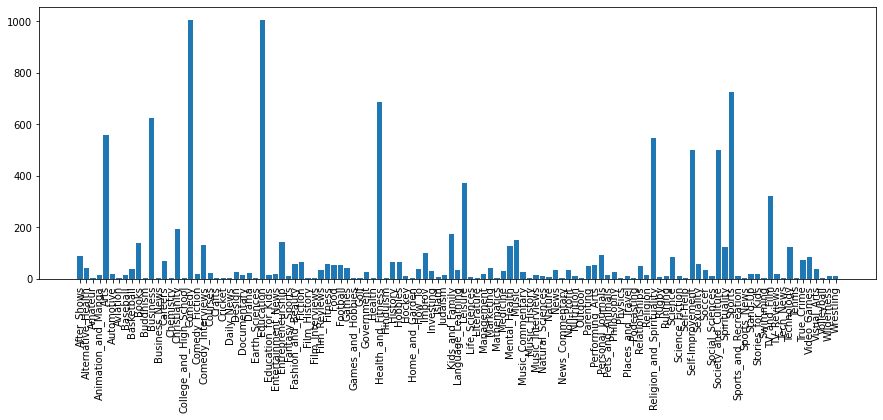

In [214]:
plt.figure(figsize=(15,5))
plt.bar(show_categories_df.columns[2:],show_categories_df.iloc[:,2:].sum())
plt.xticks(rotation=90)
plt.show()

It's clear that a number of the categories could be collapsed under a single heading (e.g. baseball, basketball, cricket could all go under sport). Let's explore how to clean this up in a different notebook.

Eventually we're also going to remove podcasts that do not have a category label, and we're going to pick just one supercategory for those that have multiple categories assigned to them. Let's see how many that might apply to.

<BarContainer object of 8 artists>

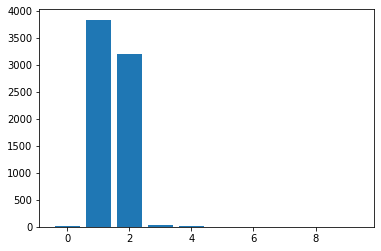

In [221]:
# multiple categories
row_sums = show_categories_df.iloc[:,2:].sum(axis=1)
plt.bar(row_sums.value_counts().index, row_sums.value_counts().values)

Finally, let's save the categories in a new file.

In [227]:
show_categories_df.to_csv('show_categories.tsv', sep='\t')